# Component z-density of CaCO3 Interfaces with Water

Author: Alec Glisman  
Date: 2024-02-02

## Imports

In [1]:
%matplotlib widget


In [2]:
# standard library
from dataclasses import dataclass
import os
from pathlib import Path

# third-party
import colorcet as cc
import cmasher as cmr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from scipy import interpolate
import sys
from tqdm.auto import tqdm

# local
dir_proj_base = Path().cwd().parents[2]
sys.path.insert(0, f"{dir_proj_base}/src")

from render.util import set_style  # noqa: E402
from data.free_energy import fes_1d # noqa: E402


In [3]:
set_style()


## Load Data

### User Inputs

In [4]:
kB = 1.38064852e-23  # [J/K]
T = 300.0  # [K]
e_electron = 1.602176634e-19  # [C]
kte_dimension = (kB * T) / e_electron  # [J/C] = [V]


In [5]:
# parameters
verbose = True
data_path = Path().cwd().parent / "data"
fig_args = {"dpi": 600, "bbox_inches": "tight"}
fig_ext = "png"
dir_output = Path().cwd() / "../data/axial_density/single-chain"

zmin = 0.1 # nm
zmax = 1.2 # nm


In [6]:
# dictionary to convert simulation labels to legend labels
label_plt = {
    "6.1": r"16-PAA",
    "6.1.0": "1",
    "6.1.1": "2",
    "6.1.2": "3",
    "6.1.3": "4",
    "6.1.4": "5",
    "6.2": r"16-PAAn",
    "6.2.0": "1",
    "6.2.1": "2",
    "6.2.2": "3",
    "6.2.3": "4",
    "6.2.4": "5",
    "6.3": r"32-PAA",
    "6.3.0": "1",
    "6.3.1": "2",
    "6.3.2": "3",
    "6.3.3": "4",
    "6.3.4": "5",
    "6.4": r"32-PAAn",
    "6.4.0": "1",
    "6.4.1": "2",
    "6.4.2": "3",
    "6.4.3": "4",
    "6.4.4": "5",
    "6.5": r"32-PAA + 32 CaCl$_2$",
    "6.5.0_20idx": "1",
    "6.5.1": "2",
    "6.5.2": "3",
    "6.5.3": "4",
    "6.5.4": "5",
}

In [7]:
dir_fig = dir_output / "figures"
dir_dat = dir_output / "data"

dir_fig.mkdir(exist_ok=True, parents=True)
dir_dat.mkdir(exist_ok=True, parents=True)


### Classes and Functions

In [8]:
@dataclass(frozen=False, order=True)
class Sim:
    """
    Dataclass for a single simulation
    """
    name: str
    sampling: str
    label: str

    colvar: pd.DataFrame
    replica: int
    
    z_surface_pos: float = 0.0
    z_sol_orient_zmin: np.ndarray = None
    z_sol_orient_zmax: np.ndarray = None
    z_sol_orient: list[np.ndarray] = None
    z_numden_osol: list[np.ndarray] = None
    z_numden_notsol: list[np.ndarray] = None
   
    z_all: list[np.ndarray] = None
  
    z_numden_na: list[np.ndarray] = None
    z_numden_ca: list[np.ndarray] = None
    z_numden_cl: list[np.ndarray] = None
    z_numden_pe: list[np.ndarray] = None 


In [9]:
def load_simulations(data_path: Path) -> list[Sim]:
    """
    Load all simulations from a directory

    Parameters
    ----------
    data_path : Path
        Path to the directory containing the simulations
    
    Returns
    -------
    list[Sim]
        List of Sim objects
    
    Raises
    ------
    FileNotFoundError
        If the data_path does not exist
    """
    file_pattern = "angulardistribution_z-resname_SOL-*"
    dir_pattern_skip = ["_replex", "axial_density"]

    # verify path exists
    if not data_path.exists():
        raise FileNotFoundError(f"{data_path} does not exist")

    # iterate over all files in the directory and load the data
    sims = []
    simulations = [x for x in data_path.iterdir() if x.is_dir()]
    simulations = [x for x in simulations if not any(y in x.name for y in dir_pattern_skip)]

    # FIXME: remove this line
    # simulations = simulations[:10]

    if verbose:
        print(f"Found {len(simulations)} simulations")
        for i, simulation in enumerate(simulations):
            print(f" - {i}: {simulation.name}")

    # iterate over all simulation systems
    for i, simulation in tqdm(enumerate(simulations), total=len(simulations), desc="Simulations", dynamic_ncols=True):
        if verbose:
            print(f" - Processing {simulation.name}")

        # iterate over all sampling methods
        sampling_methods = [x for x in simulation.iterdir() if x.is_dir()]
        sampling_methods = [x for x in sampling_methods if not any(y in x.name for y in dir_pattern_skip)]
        for sampling_method in sampling_methods:
            # FIXME: remove this line
            if sampling_method.name.split("_")[-1] != "00":
                continue

            if verbose:
                print(f"   - Sampling: {sampling_method.name}")

            # find all solvent orientation files
            dir_orient = sampling_method / "mdanalysis_angulardistribution/data"
            files_orient = sorted(list(dir_orient.glob(file_pattern)))
            z_min_orient = [float(x.name.split("-")[2].split("_")[0]) for x in files_orient]
            z_max_orient = [float(x.name.split("-")[3].split("_")[0]) for x in files_orient]
            if verbose:
                print(f"     Found {len(files_orient)} solvent orientation files")
            
            # create simulation object
            sim = Sim(
                name=simulation.name,
                sampling=sampling_method.name,
                label=simulation.name.split("-")[0],
                colvar=pd.read_parquet(sampling_method / f"plumed/colvar_{sampling_method.name}.parquet"),
                replica=int(sampling_method.name.split("_")[-1]),
                z_sol_orient=[np.load(x) for x in files_orient],
                z_sol_orient_zmin=np.array(z_min_orient),
                z_sol_orient_zmax=np.array(z_max_orient),
                z_all=np.load(
                    sampling_method
                    / f"mdanalysis_lineardensity/data/lineardensity_z_all_atoms.npz"
                ) if (sampling_method / f"mdanalysis_lineardensity/data/lineardensity_z_all_atoms.npz").exists() else None,
                z_numden_osol=np.load(
                    sampling_method
                    / f"mdanalysis_lineardensity/data/lineardensity_z_resname_SOL_and_name_OW_atoms.npz"
                ) if (sampling_method / f"mdanalysis_lineardensity/data/lineardensity_z_resname_SOL_and_name_OW_atoms.npz").exists() else None,
                z_numden_notsol=np.load(
                    sampling_method
                    / f"mdanalysis_lineardensity/data/lineardensity_z_not_resname_SOL_atoms.npz"
                ) if (sampling_method / f"mdanalysis_lineardensity/data/lineardensity_z_not_resname_SOL_atoms.npz").exists() else None,
                z_numden_ca=np.load(
                    sampling_method
                    / f"mdanalysis_lineardensity/data/lineardensity_z_resname_CA_and_name_CA_atoms.npz"
                ) if (sampling_method / f"mdanalysis_lineardensity/data/lineardensity_z_resname_CA_and_name_CA_atoms.npz").exists() else None,
                z_numden_na=np.load(
                    sampling_method
                    / f"mdanalysis_lineardensity/data/lineardensity_z_resname_NA_and_name_NA_atoms.npz"
                ) if (sampling_method / f"mdanalysis_lineardensity/data/lineardensity_z_resname_NA_and_name_NA_atoms.npz").exists() else None,
                z_numden_cl=np.load(
                    sampling_method
                    / f"mdanalysis_lineardensity/data/lineardensity_z_resname_CL_and_name_CL_atoms.npz"
                ) if (sampling_method / f"mdanalysis_lineardensity/data/lineardensity_z_resname_CL_and_name_CL_atoms.npz").exists() else None,
                z_numden_pe=np.load(
                    sampling_method
                    / f"mdanalysis_lineardensity/data/lineardensity_z_resname_LAI_ACI_RAI_AI1_LAN_ACN_RAN_AN1_LAC_ACE_RAC_AC1_LAL_ALC_RAL_AL1_residues.npz"
                ) if (sampling_method / f"mdanalysis_lineardensity/data/lineardensity_z_resname_LAI_ACI_RAI_AI1_LAN_ACN_RAN_AN1_LAC_ACE_RAC_AC1_LAL_ALC_RAL_AL1_residues.npz").exists() else None,
            )
            sims.append(sim)

    return sims


### Script

In [10]:
sims = load_simulations(data_path)

print(f"Loaded {len(sims)} simulations")
for i, sim in enumerate(sims):
    print(f" - {i}: {sim.name} ({sim.sampling})")
    

Found 19 simulations
 - 0: 6.1.0-calcite-104surface-9nm_surface-10nm_vertical-1chain-PAcr-16mer-0Crb-0Ca-16Na-0Cl-300K-1bar-NVT
 - 1: 6.1.1-calcite-104surface-9nm_surface-10nm_vertical-1chain-PAcr-16mer-0Crb-0Ca-16Na-0Cl-300K-1bar-NVT
 - 2: 6.1.2-calcite-104surface-9nm_surface-10nm_vertical-1chain-PAcr-16mer-0Crb-0Ca-16Na-0Cl-300K-1bar-NVT
 - 3: 6.1.3-calcite-104surface-9nm_surface-10nm_vertical-1chain-PAcr-16mer-0Crb-0Ca-16Na-0Cl-300K-1bar-NVT
 - 4: 6.1.4-calcite-104surface-9nm_surface-10nm_vertical-1chain-PAcr-16mer-0Crb-0Ca-16Na-0Cl-300K-1bar-NVT
 - 5: 6.2.0-calcite-104surface-9nm_surface-10nm_vertical-1chain-PAcn-16mer-0Crb-0Ca-0Na-0Cl-300K-1bar-NVT
 - 6: 6.2.1-calcite-104surface-9nm_surface-10nm_vertical-1chain-PAcn-16mer-0Crb-0Ca-0Na-0Cl-300K-1bar-NVT
 - 7: 6.2.2-calcite-104surface-9nm_surface-10nm_vertical-1chain-PAcn-16mer-0Crb-0Ca-0Na-0Cl-300K-1bar-NVT
 - 8: 6.2.3-calcite-104surface-9nm_surface-10nm_vertical-1chain-PAcn-16mer-0Crb-0Ca-0Na-0Cl-300K-1bar-NVT
 - 9: 6.2.4-calcite-

Simulations:   0%|          | 0/19 [00:00<?, ?it/s]

 - Processing 6.1.0-calcite-104surface-9nm_surface-10nm_vertical-1chain-PAcr-16mer-0Crb-0Ca-16Na-0Cl-300K-1bar-NVT
   - Sampling: opes-one-replica_00
     Found 122 solvent orientation files
 - Processing 6.1.1-calcite-104surface-9nm_surface-10nm_vertical-1chain-PAcr-16mer-0Crb-0Ca-16Na-0Cl-300K-1bar-NVT
   - Sampling: opes-one-replica_00
     Found 122 solvent orientation files
 - Processing 6.1.2-calcite-104surface-9nm_surface-10nm_vertical-1chain-PAcr-16mer-0Crb-0Ca-16Na-0Cl-300K-1bar-NVT
   - Sampling: opes-one-replica_00
     Found 122 solvent orientation files
 - Processing 6.1.3-calcite-104surface-9nm_surface-10nm_vertical-1chain-PAcr-16mer-0Crb-0Ca-16Na-0Cl-300K-1bar-NVT
   - Sampling: opes-one-replica_00
     Found 122 solvent orientation files
 - Processing 6.1.4-calcite-104surface-9nm_surface-10nm_vertical-1chain-PAcr-16mer-0Crb-0Ca-16Na-0Cl-300K-1bar-NVT
   - Sampling: opes-one-replica_00
     Found 122 solvent orientation files
 - Processing 6.2.0-calcite-104surface-9nm_su

In [11]:
# sim.label is of the form "\d.\d.\d", split it into its components
idx_1, idx_2, idx_3 = [], [], []
for sim in sims:
    idx_1.append(sim.label.split(".")[0])
    idx_2.append(sim.label.split(".")[1])
    idx_3.append(sim.label.split(".")[2])

# where idx_1, idx_2 is the same, group the simulations into a list
grouped_sims = []
for i, sim in enumerate(sims):
    for j, group in enumerate(grouped_sims):
        if idx_1[i] == group[0].label.split(".")[0] and idx_2[i] == group[0].label.split(".")[1]:
            grouped_sims[j].append(sim)
            break
    else:
        grouped_sims.append([sim])

# convert grouped_sims to a tuple with the first element being the label and second the list of simulations
grouped_sims = [(x[0].label[:3], x) for x in grouped_sims]  

print(f"Grouped {len(grouped_sims)} systems")
for i, group in enumerate(grouped_sims):
    print(f" - {i}: {group[0]} ({len(group[1])} simulations)")

Grouped 5 systems
 - 0: 6.1 (5 simulations)
 - 1: 6.2 (5 simulations)
 - 2: 6.3 (5 simulations)
 - 3: 6.4 (3 simulations)
 - 4: 6.5 (1 simulations)


In [12]:
def save_fig(
    data: dict[str, np.ndarray],
    fig: plt.Figure, 
    figname: str,
    dir_dat: Path,
    dir_fig: Path, 
    ext: str = "png",
    fig_args: dict[str, any] = {"dpi": 600, "bbox_inches": "tight"}
) -> None:
    """
    Save a figure to a directory

    Parameters
    ----------
    data : dict[str, np.ndarray]
        Dictionary of data to save
    fig : plt.Figure
        Figure to save
    figname : str
        Name of the figure
    dir_dat : Path
        Directory to save the data
    dir_fig : Path
        Directory to save the figure
    ext : str
        Extension of the figure
    fig_args : dict[str, any]
        Arguments to pass to fig.savefig()
    """
    # pad data with NaNs
    max_length = max([len(value) for value in data.values()])
    for key, value in data.items():
        data[key] = np.pad(value, (0, max_length - len(value)), mode="constant", constant_values=np.nan)

    # save the figure
    df = pd.DataFrame(data)
    df.to_csv(dir_dat / f"{figname}.csv", index=False)
    fig.savefig(dir_fig / f"{figname}.{ext}", **fig_args)


## Find CaCO3 surface z-coordinate

System:   0%|          | 0/5 [00:00<?, ?it/s]

Simulation:   0%|          | 0/5 [00:00<?, ?it/s]

Simulation: opes-one-replica_00 - 6.1.0
  Surface position [A]: 24.1
Simulation: opes-one-replica_00 - 6.1.1
  Surface position [A]: 24.1
Simulation: opes-one-replica_00 - 6.1.2
  Surface position [A]: 24.1
Simulation: opes-one-replica_00 - 6.1.3
  Surface position [A]: 24.2
Simulation: opes-one-replica_00 - 6.1.4
  Surface position [A]: 24.1


Simulation:   0%|          | 0/5 [00:00<?, ?it/s]

Simulation: opes-one-replica_00 - 6.2.0
  Surface position [A]: 24.2
Simulation: opes-one-replica_00 - 6.2.1
  Surface position [A]: 24.2
Simulation: opes-one-replica_00 - 6.2.2
  Surface position [A]: 24.2
Simulation: opes-one-replica_00 - 6.2.3
  Surface position [A]: 24.2
Simulation: opes-one-replica_00 - 6.2.4
  Surface position [A]: 24.2


Simulation:   0%|          | 0/5 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Simulation: opes-one-replica_00 - 6.3.0
  Skipping simulation
Simulation: opes-one-replica_00 - 6.3.1
  Skipping simulation
Simulation: opes-one-replica_00 - 6.3.2
  Skipping simulation
Simulation: opes-one-replica_00 - 6.3.3
  Skipping simulation
Simulation: opes-one-replica_00 - 6.3.4
  Skipping simulation


Simulation:   0%|          | 0/3 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Simulation: opes-one-replica_00 - 6.4.0
  Skipping simulation
Simulation: opes-one-replica_00 - 6.4.2
  Skipping simulation
Simulation: opes-one-replica_00 - 6.4.3
  Skipping simulation


Simulation:   0%|          | 0/1 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Simulation: opes-one-replica_00 - 6.5.0_20idx
  Skipping simulation


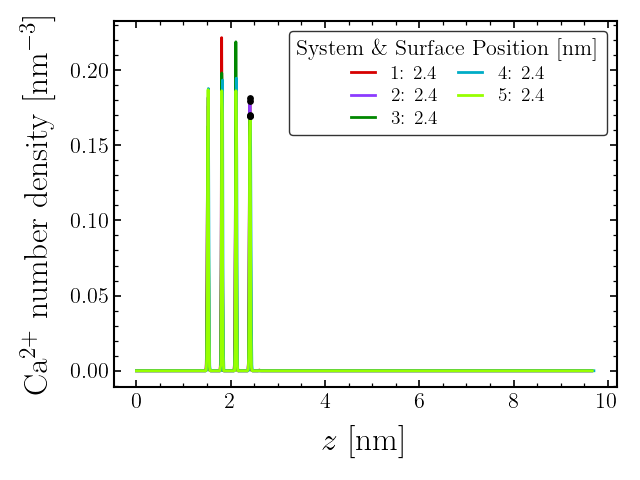

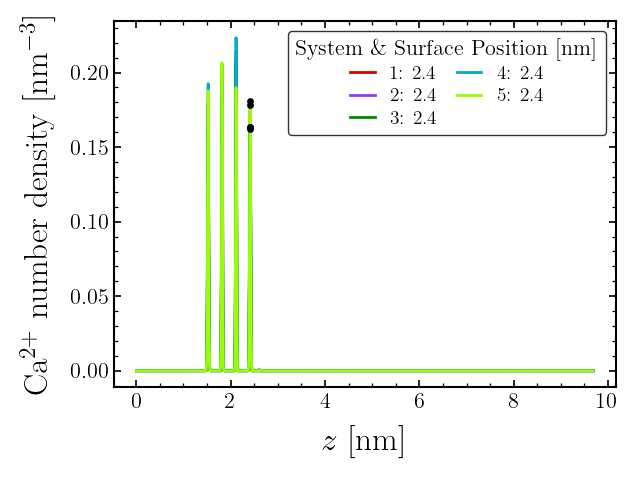

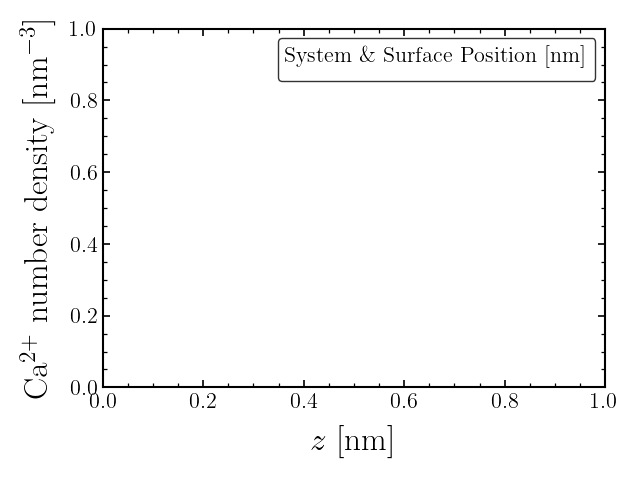

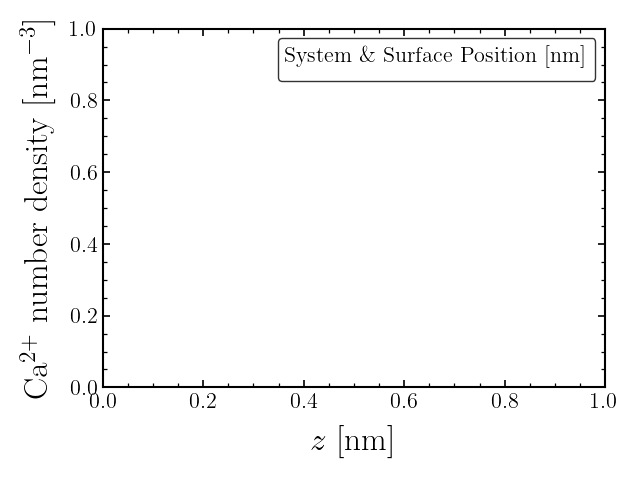

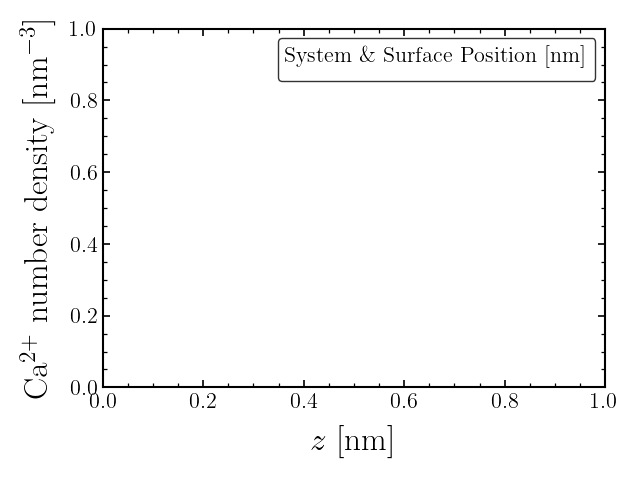

In [13]:
# find surface z-coordinate as last major peak in the number density profile
cmap = cc.glasbey

for i, group in tqdm(enumerate(grouped_sims), desc="System", dynamic_ncols=True, total=len(grouped_sims)):
    label, sims = group[0], group[1]
    
    fig, ax = plt.subplots()
    ax.set_xlabel(r"$z$ [nm]")
    ax.set_ylabel(r"Ca$^{2+}$ number density [nm$^{-3}$]")

    for j, sim in tqdm(enumerate(sims), desc="Simulation", dynamic_ncols=True, total=len(sims), leave=False):
        try:
            z_ca = sim.z_numden_ca["number_density"]
            z_pos = sim.z_numden_ca["position"]
            maxima, _ = find_peaks(z_ca, distance=10, prominence=0.001)
            sim.z_surface_pos = np.round(z_pos[maxima[-1]], decimals=1)

            ax.plot(z_pos/10.0, z_ca, color=cmap[j], label=f"{label_plt[sim.label]}: {sim.z_surface_pos/10:.1f}")
            ax.scatter(sim.z_surface_pos/10, z_ca[maxima[-1]], color="black", s=15, zorder=20)
        
        except Exception as e:
            print(f"Simulation: {sim.sampling} - {sim.label}")
            print(f"  Skipping simulation")
            continue

        if verbose:
            print(f"Simulation: {sim.sampling} - {sim.label}")
            print(f"  Surface position [A]: {sim.z_surface_pos:.1f}")
    
    ax.legend(title=r"System \& Surface Position [nm]", loc="upper right", ncol=2)

    # save data
    tags, z_pos = [], []
    for sim in sims:
        tags.append(sim.name + "_" + sim.sampling)
        z_pos.append(sim.z_surface_pos)
    df = pd.DataFrame({"tag": tags, "z_surface_pos_ang": z_pos})
    df.to_csv(dir_dat / f"z_surface_pos_{label}.csv", index=False)
    fig.tight_layout()
    fig.savefig(dir_fig / f"z_surface_pos_{label}.{fig_ext}", **fig_args)


## Chain-Calcite PMF

In [14]:
bandwidth = 0.1
eqbm_percent = 0.1
cv_plateau = (2.2, 2.6)
offset = 0.303
bins = np.linspace(0.2, 4.5, 300)
z_score = 1.96


System:   0%|          | 0/5 [00:00<?, ?it/s]

Simulation:   0%|          | 0/5 [00:00<?, ?it/s]

Simulation:   0%|          | 0/5 [00:00<?, ?it/s]

Simulation:   0%|          | 0/5 [00:00<?, ?it/s]

Simulation:   0%|          | 0/3 [00:00<?, ?it/s]

Simulation:   0%|          | 0/1 [00:00<?, ?it/s]

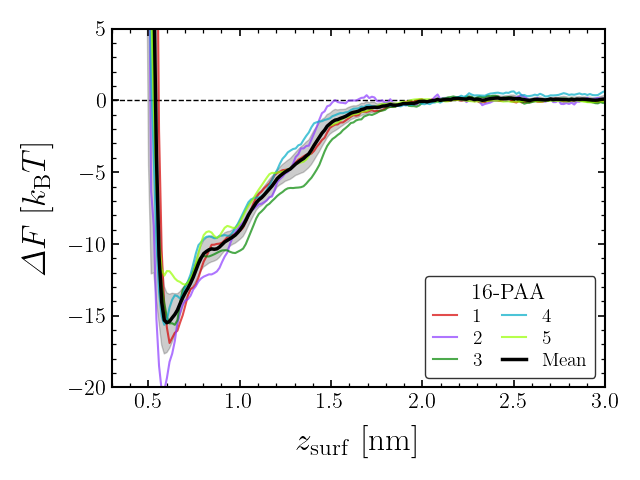

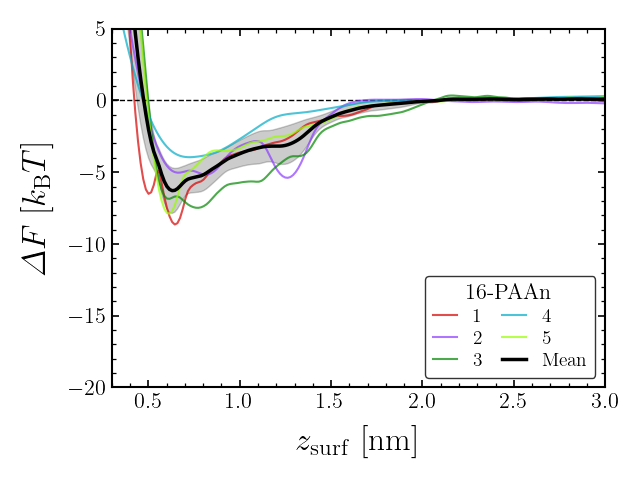

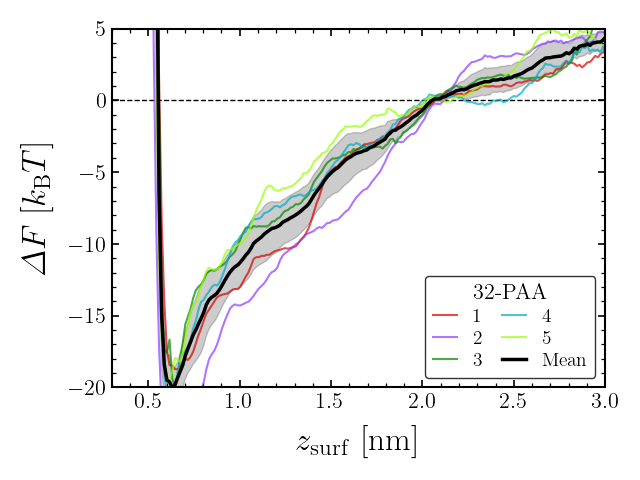

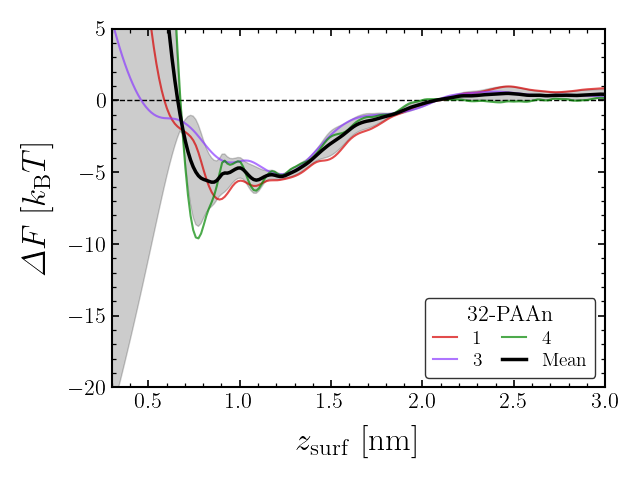

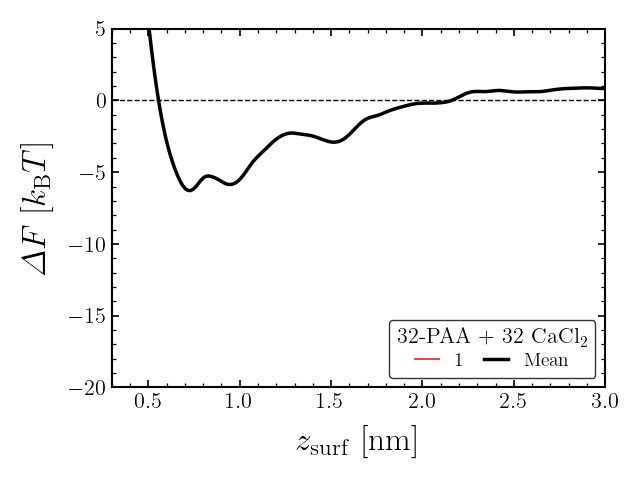

In [15]:
# find surface z-coordinate as last major peak in the number density profile
cmap = cc.glasbey

overall_data = {"x": bins - offset}
for i, group in tqdm(
    enumerate(grouped_sims), desc="System", dynamic_ncols=True, total=len(grouped_sims)
):
    label, sims = group[0], group[1]
    data = {"x": bins - offset}
    
    fname = f"dist_chain_z_pmf_{label}"
    fig, ax = plt.subplots()
    ax.set_xlabel(r"$z_{\mathrm{surf}}$ [nm]")
    ax.set_xlim(0.3, 3.0)
    ax.set_ylabel(r"$\Delta F$ [$k_{\mathrm{B}}T$]")
    ax.set_ylim(-20, 5)
    ax.axhline(0, color="black", linewidth=1, linestyle="--")

    for j, sim in tqdm(
        enumerate(sims),
        desc="Simulation",
        dynamic_ncols=True,
        total=len(sims),
        leave=False,
    ):
        df = sim.colvar
        _, pmf = fes_1d(
            x=df["dist_chain.z"].to_numpy(),
            cv_grid=bins,
            bandwidth=bandwidth,
            weights=df["weight"].to_numpy(),
            eqbm_percent=eqbm_percent,
            plateau_domain=cv_plateau,
        )
        data[f"y_{j}"] = pmf
        ax.plot(
            bins - offset, pmf, label=label_plt[sim.label],
            color=cmap[j], linewidth=1.5, alpha=0.7
        )

    # average to get the mean and standard deviation
    pmf_mean = np.nanmean([data[f"y_{k}"] for k in range(len(sims))], axis=0)
    pmf_std = np.nanstd([data[f"y_{k}"] for k in range(len(sims))], axis=0) / np.sqrt(len(sims))
    ax.plot(bins - offset, pmf_mean, label="Mean", color="black", linewidth=2.5)
    ax.fill_between(
            bins - offset,
            pmf_mean - z_score * pmf_std,
            pmf_mean + z_score * pmf_std,
            color="black",
            alpha=0.2,
    )
    data["y_mean"] = pmf_mean
    data["y_std"] = pmf_std
    overall_data[f"y_{i}"] = pmf_mean
    overall_data[f"y_err_{i}"] = pmf_std

    ax.legend(loc="lower right", ncols=2, title=label_plt[label])
    fig.tight_layout()

    save_fig(data, fig, fname, dir_dat, dir_fig, fig_ext, fig_args)


System:   0%|          | 0/5 [00:00<?, ?it/s]

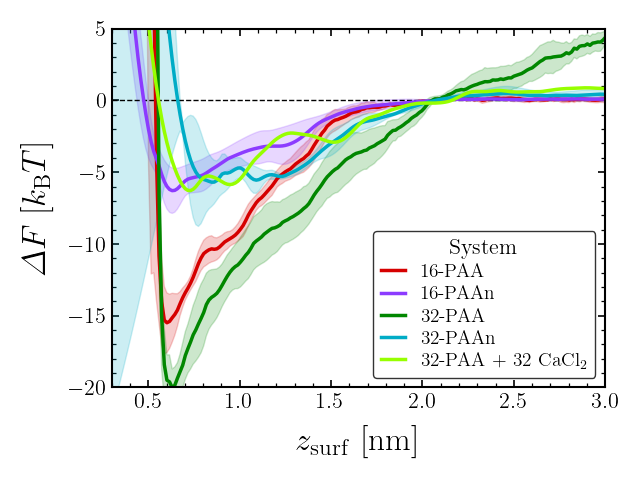

In [16]:
fname = f"dist_chain_z_pmf_avg"
fig, ax = plt.subplots()
ax.set_xlabel(r"$z_{\mathrm{surf}}$ [nm]")
ax.set_xlim(0.3, 3.0)
ax.set_ylabel(r"$\Delta F$ [$k_{\mathrm{B}}T$]")
ax.set_ylim(-20, 5)
ax.axhline(0, color="black", linewidth=1, linestyle="--")

for i, group in tqdm(
    enumerate(grouped_sims), desc="System", dynamic_ncols=True, total=len(grouped_sims)
):
    ax.plot(
        overall_data["x"],
        overall_data[f"y_{i}"],
        label=label_plt[group[0]],
        color=cmap[i],
        linewidth=2.5,
    )
    ax.fill_between(
        overall_data["x"],
        overall_data[f"y_{i}"] - z_score * overall_data[f"y_err_{i}"],
        overall_data[f"y_{i}"] + z_score * overall_data[f"y_err_{i}"],
        color=cmap[i],
        alpha=0.2,
    )

fig.tight_layout()
ax.legend(title="System", loc="lower right", ncols=1)
save_fig(overall_data, fig, fname, dir_dat, dir_fig, fig_ext, fig_args)
plt.show()


## z Number Density Profiles

### O_sol

System:   0%|          | 0/5 [00:00<?, ?it/s]

Simulation:   0%|          | 0/5 [00:00<?, ?it/s]

Simulation:   0%|          | 0/5 [00:00<?, ?it/s]

Simulation:   0%|          | 0/5 [00:00<?, ?it/s]

TypeError: 'NoneType' object is not subscriptable

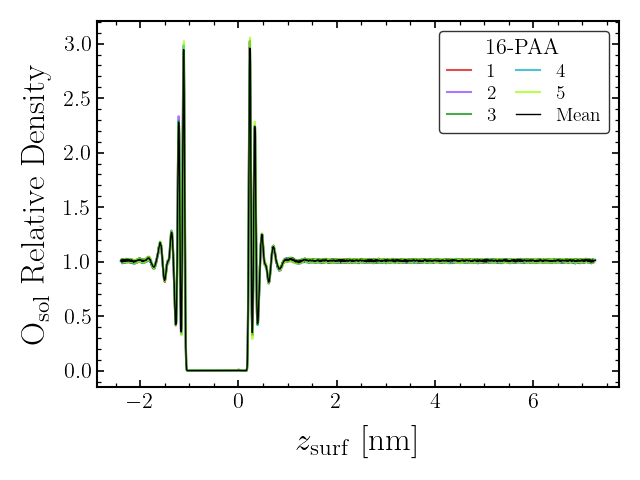

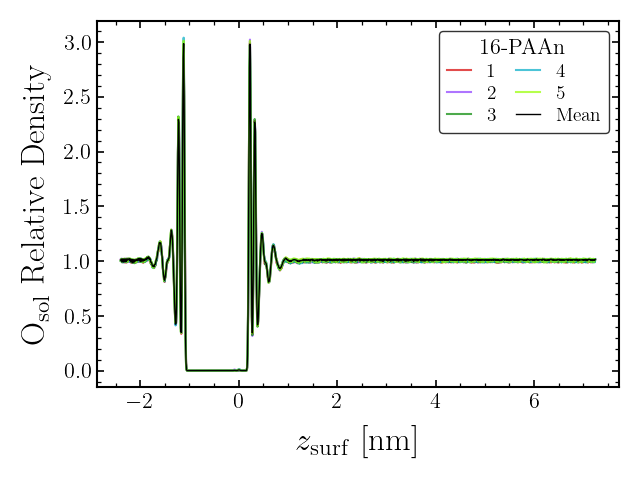

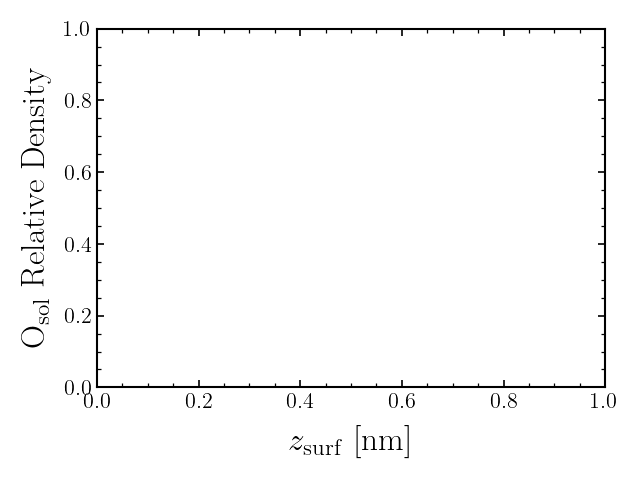

: 

In [17]:
cmap = cc.glasbey
window = 4

overall_data = {}
for i, group in tqdm(
    enumerate(grouped_sims), desc="System", dynamic_ncols=True, total=len(grouped_sims)
):
    label, sims = group[0], group[1]
    data = {}

    fname = f"osol_density_z_{label}"
    fig, ax = plt.subplots()
    ax.set_xlabel(r"$z_{\mathrm{surf}}$ [nm]")
    ax.set_ylabel(r"O$_{\mathrm{sol}}$ Relative Density")

    for j, sim in tqdm(
        enumerate(sims),
        desc="Simulation",
        dynamic_ncols=True,
        total=len(sims),
        leave=False,
    ):
        x = (sim.z_numden_osol["position"] - sim.z_surface_pos) / 10.0
        y = sim.z_numden_osol["number_density"] / np.average(sim.z_numden_osol["number_density"][-10:])
        # smooth data
        y = np.convolve(y, np.ones(window) / window, mode="same")
        # drop first and last two points
        x = x[2:-2]
        y = y[2:-2]
        data[f"x_{j}"] = x
        data[f"y_{j}"] = y

        ax.plot(x, y, label=label_plt[sim.label], color=cmap[j], linewidth=1.5, alpha=0.7)

    # average y-data on x-data
    x = np.unique(np.concatenate([data[f"x_{j}"] for j in range(len(sims))]))
    y = np.zeros((len(sims), len(x)))
    for j in range(len(sims)):
        y[j] = np.interp(x, data[f"x_{j}"], data[f"y_{j}"])
    y_mean = np.nanmean(y, axis=0)
    y_std = np.nanstd(y, axis=0) / np.sqrt(len(sims))
    overall_data[f"x_{i}"] = x
    overall_data[f"y_{i}"] = y_mean
    overall_data[f"y_err_{i}"] = y_std
    
    ax.plot(x, y_mean, label="Mean", color="black", linewidth=1.0)
    ax.fill_between(
        x,
        y_mean - z_score * y_std,
        y_mean + z_score * y_std,
        color="black",
        alpha=0.2,
    )

    ax.legend(loc="upper right", title=label_plt[label], ncol=2)
    fig.tight_layout()
    save_fig(data, fig, fname, dir_dat, dir_fig, fig_ext, fig_args)


In [ ]:
fname = "osol_density_z"
fig, ax = plt.subplots()
ax.set_xlabel(r"$z_{\mathrm{surf}}$ [nm]")
ax.set_ylabel(r"O$_{\mathrm{sol}}$ Relative Density")

for i, group in tqdm(
    enumerate(grouped_sims), desc="System", dynamic_ncols=True, total=len(grouped_sims)
):
    ax.plot(
        overall_data[f"x_{i}"],
        overall_data[f"y_{i}"],
        label=label_plt[group[0]],
        color=cmap[i],
        linewidth=2,
    )
    ax.fill_between(
        overall_data[f"x_{i}"],
        overall_data[f"y_{i}"] - z_score * overall_data[f"y_err_{i}"],
        overall_data[f"y_{i}"] + z_score * overall_data[f"y_err_{i}"],
        color=cmap[i],
        alpha=0.2,
    )

fig.tight_layout()
ax.legend(title="System", loc="lower right", ncols=1)
save_fig(overall_data, fig, fname, dir_dat, dir_fig, fig_ext, fig_args)
plt.show()


In [ ]:
fname = "osol_density_z_interface"
fig, ax = plt.subplots()
ax.set_xlabel(r"$z_{\mathrm{surf}}$ [nm]")
ax.set_xlim(zmin, zmax)
ax.set_ylabel(r"O$_{\mathrm{sol}}$ Relative Density")

for i, group in tqdm(
    enumerate(grouped_sims), desc="System", dynamic_ncols=True, total=len(grouped_sims)
):
    ax.plot(
        overall_data[f"x_{i}"],
        overall_data[f"y_{i}"],
        label=label_plt[group[0]],
        color=cmap[i],
        linewidth=2,
    )
    ax.fill_between(
        overall_data[f"x_{i}"],
        overall_data[f"y_{i}"] - z_score * overall_data[f"y_err_{i}"],
        overall_data[f"y_{i}"] + z_score * overall_data[f"y_err_{i}"],
        color=cmap[i],
        alpha=0.2,
    )

fig.tight_layout()
ax.legend(title="System", loc="lower right", ncols=1)
save_fig(overall_data, fig, fname, dir_dat, dir_fig, fig_ext, fig_args)
plt.show()


In [ ]:
# print positions of first four maxima and minima of the previous plot
data = {}
for i, group in enumerate(grouped_sims):
    label, sims = group[0], group[1]

    x = overall_data[f"x_{i}"]
    y = overall_data[f"y_{i}"]
    # restrict data in range 0.1 to 1.0
    mask = (x >= zmin) & (x <= zmax)
    x = x[mask]
    y = y[mask]
    # find peaks
    maxima, _ = find_peaks(y, prominence=0.01)
    minima, _ = find_peaks(-y, prominence=0.01)
    # restrict precision to 2 decimal places
    x = np.round(x, 2)
    data[f"{label}_maxima"] = x[maxima[:4]]
    data[f"{label}_minima"] = x[minima[:4]]

    print(f"{label_plt[label]}")
    print(f"  Maxima: {x[maxima[:4]]}")
    print(f"  Minima: {x[minima[:4]]}")


df = pd.DataFrame(data)
df.to_csv(dir_dat / "osol_density_z_interface_peaks.csv", index=False)
df


### Polyelectrolyte

In [ ]:
window = 5
cmap = cc.glasbey

In [ ]:
overall_data = {}
for i, group in tqdm(
    enumerate(grouped_sims), desc="System", dynamic_ncols=True, total=len(grouped_sims)
):
    label, sims = group[0], group[1]
    data = {}

    fname = f"pe_density_z_{label}"
    fig, ax = plt.subplots()
    ax.set_xlabel(r"$z_{\mathrm{surf}}$ [nm]")
    ax.set_xlim(0.2, 2)
    ax.set_ylabel(r"Monomer Density [nm$^{-3}$]")

    for j, sim in tqdm(
        enumerate(sims),
        desc="Simulation",
        dynamic_ncols=True,
        total=len(sims),
        leave=False,
    ):
        x = (sim.z_numden_pe["position"] - sim.z_surface_pos) / 10.0
        y = sim.z_numden_pe["number_density"]
        # smooth data
        y = np.convolve(y, np.ones(window) / window, mode="same")
        # drop first and last two points
        x = x[2:-2]
        y = y[2:-2]
        data[f"x_{j}"] = x
        data[f"y_{j}"] = y

        ax.plot(x, y, label=label_plt[sim.label], color=cmap[j], linewidth=1.5, alpha=0.7)

    # average y-data on x-data
    x = np.unique(np.concatenate([data[f"x_{j}"] for j in range(len(sims))]))
    y = np.zeros((len(sims), len(x)))
    for j in range(len(sims)):
        y[j] = np.interp(x, data[f"x_{j}"], data[f"y_{j}"])
    y_mean = np.nanmean(y, axis=0)
    y_std = np.nanstd(y, axis=0) / np.sqrt(len(sims))
    overall_data[f"x_{i}"] = x
    overall_data[f"y_{i}"] = y_mean
    overall_data[f"y_err_{i}"] = y_std
    
    ax.plot(x, y_mean, label="Mean", color="black", linewidth=1.0)
    ax.fill_between(
        x,
        y_mean - z_score * y_std,
        y_mean + z_score * y_std,
        color="black",
        alpha=0.2,
    )

    ax.legend(loc="upper right", title=label_plt[label], ncol=2)
    fig.tight_layout()
    save_fig(data, fig, fname, dir_dat, dir_fig, fig_ext, fig_args)


In [ ]:
fname = f"pe_density_z_{label}"
fig, ax = plt.subplots()
ax.set_xlabel(r"$z_{\mathrm{surf}}$ [nm]")
ax.set_xlim(0.2, 2)
ax.set_ylabel(r"Monomer Density [nm$^{-3}$]")

for i, group in tqdm(
    enumerate(grouped_sims), desc="System", dynamic_ncols=True, total=len(grouped_sims)
):
    ax.plot(
        overall_data[f"x_{i}"],
        overall_data[f"y_{i}"],
        label=label_plt[group[0]],
        color=cmap[i],
        linewidth=2,
    )
    ax.fill_between(
        overall_data[f"x_{i}"],
        overall_data[f"y_{i}"] - z_score * overall_data[f"y_err_{i}"],
        overall_data[f"y_{i}"] + z_score * overall_data[f"y_err_{i}"],
        color=cmap[i],
        alpha=0.2,
    )

fig.tight_layout()
ax.legend(title="System", loc="upper right", ncols=1)
save_fig(overall_data, fig, fname, dir_dat, dir_fig, fig_ext, fig_args)
plt.show()

### Calcium

In [ ]:
def plot_ion_density(
        ion_group: str,
        grouped_sims: list[tuple[str, list[Sim]]],
        window: int = 4,
        cmap: list[str] = cc.glasbey,
        xrange: tuple[float, float] = (None, None),
        z_score: float = 1.96,
) -> None:
    overall_data = {}

    if ion_group == "ca":
        name = f"ca_density_z"
        xlabel = r"$z_{\mathrm{surf}}$ [nm]"
        ylabel = r"Ca$^{2+}$ Relative Density"
    
    elif ion_group == "na":
        name = f"na_density_z"
        xlabel = r"$z_{\mathrm{surf}}$ [nm]"
        ylabel = r"Na$^{+}$ Relative Density"

    elif ion_group == "cl":
        name = f"cl_density_z"
        xlabel = r"$z_{\mathrm{surf}}$ [nm]"
        ylabel = r"Cl$^{-}$ Relative Density"
    
    else:
        raise ValueError(f"Invalid ion group: {ion_group}")

    if xrange != (None, None):
        name = f"{name}_{xrange[0]}_{xrange[1]}"

    # iterate through systems
    for i, group in tqdm(
        enumerate(grouped_sims), desc="System", dynamic_ncols=True, total=len(grouped_sims)
    ):
        label, sims = group[0], group[1]
        data = {}

        fname = f"{name}_{label}"
        fig, ax = plt.subplots()
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

        # iterate through simulation replicates
        for j, sim in tqdm(
            enumerate(sims),
            desc="Simulation",
            dynamic_ncols=True,
            total=len(sims),
            leave=False,
        ):
            # select the correct number density data
            if ion_group == "ca":
                df = sim.z_numden_ca
            elif ion_group == "na":
                df = sim.z_numden_na
            elif ion_group == "cl":
                df = sim.z_numden_cl
            
            if df is None:
                print(f"Simulation: {sim.sampling} - {sim.label}")
                print(f"  Skipping simulation")
                continue

            x = (df["position"] - sim.z_surface_pos) / 10.0
            y = df["number_density"] / np.average(df["number_density"][-10:])
            
            # smooth data
            y = np.convolve(y, np.ones(window) / window, mode="same")
            # drop data
            if xrange != (None, None):
                mask = (x >= xrange[0]) & (x <= xrange[1])
                x = x[mask]
                y = y[mask]
            else: 
                x = x[2:-2]
                y = y[2:-2]
            # output data
            data[f"x_{j}"] = x
            data[f"y_{j}"] = y

            ax.plot(x, y, label=label_plt[sim.label], color=cmap[j], linewidth=1.5, alpha=0.7)

        # average y-data on x-data
        if len(data) > 0:
            x = np.unique(np.concatenate([data[f"x_{j}"] for j in range(len(sims))]))
            y = np.zeros((len(sims), len(x)))
            for j in range(len(sims)):
                y[j] = np.interp(x, data[f"x_{j}"], data[f"y_{j}"])
            y_mean = np.nanmean(y, axis=0)
            y_std = np.nanstd(y, axis=0) / np.sqrt(len(sims))
            overall_data[f"x_{i}"] = x
            overall_data[f"y_{i}"] = y_mean
            overall_data[f"y_err_{i}"] = y_std
        
            ax.plot(x, y_mean, label="Mean", color="black", linewidth=1.0)
            ax.fill_between(
                x,
                y_mean - z_score * y_std,
                y_mean + z_score * y_std,
                color="black",
                alpha=0.2,
            )

        ax.legend(loc="upper right", title=label_plt[label], ncol=2)
        fig.tight_layout()
        if len(data) > 0:
            save_fig(data, fig, fname, dir_dat, dir_fig, fig_ext, fig_args)
        else:
            plt.close(fig)
    
    fname = f"{name}_avg"
    fig, ax = plt.subplots()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    for i, group in tqdm(
        enumerate(grouped_sims), desc="System", dynamic_ncols=True, total=len(grouped_sims)
    ):
        try:
            ax.plot(
                overall_data[f"x_{i}"],
                overall_data[f"y_{i}"],
                label=label_plt[group[0]],
                color=cmap[i],
                linewidth=2,
            )
            ax.fill_between(
                overall_data[f"x_{i}"],
                overall_data[f"y_{i}"] - z_score * overall_data[f"y_err_{i}"],
                overall_data[f"y_{i}"] + z_score * overall_data[f"y_err_{i}"],
                color=cmap[i],
                alpha=0.2,
            )
        except KeyError:
            continue
    
    fig.tight_layout()
    ax.legend(title="System", loc="upper right", ncols=1)
    if len(overall_data) > 0:
        save_fig(overall_data, fig, fname, dir_dat, dir_fig, fig_ext, fig_args)
    else:
        plt.close(fig)


In [ ]:
window = 5
cmap = cc.glasbey

In [ ]:
plot_ion_density("na", grouped_sims, window, cmap, (zmin, zmax), z_score)

In [ ]:
plot_ion_density("cl", grouped_sims, window, cmap, (zmin, zmax), z_score)

In [ ]:
plot_ion_density("ca", grouped_sims, window, cmap, (zmin, zmax), z_score)

In [ ]:
cmap = cc.glasbey
figname = "ca_density_z"
fig, ax = plt.subplots()
ax.set_xlabel(r"$z_{\mathrm{surf}}$ [nm]")
ax.set_ylabel(r"Ca$^{2+}$ Relative Density")
window = 4

data = {}
for i, sim in enumerate(sims):
    if "Ca" not in sim.label:
        continue

    x = (sim.z_numden_ca["position"] - sim.z_surface_pos) / 10.0
    y = sim.z_numden_ca["number_density"] / np.average(
        sim.z_numden_ca["number_density"][-200:-120]
    )
    y = np.convolve(y, np.ones(window), "same") / window
    idx_drop = np.where((x < zmin) | (x > zmax + 1))
    x = np.delete(x, idx_drop)
    y = np.delete(y, idx_drop)
    data[f"line_{i}_x"] = x
    data[f"line_{i}_y"] = y

    ax.plot(x, y, label=sim.label, color=cmap[sims.index(sim)])

ax.legend(title="System", loc="upper right", ncol=2)

if len(data) > 0:
    save_fig(data, fig, figname, dir_dat, dir_fig, fig_ext, fig_args)
    plt.show()


## z Charge Density Profiles

In [ ]:
window = 10
cmap = cc.glasbey

In [ ]:
overall_data = {}
for i, group in tqdm(
    enumerate(grouped_sims), desc="System", dynamic_ncols=True, total=len(grouped_sims)
):
    label, sims = group[0], group[1]
    data = {}

    fname = f"all_chargedensity_z_{label}"
    fig, ax = plt.subplots()
    ax.set_xlabel(r"$z_{\mathrm{surf}}$ [nm]")
    ax.set_ylabel(r"Charge Density [$e$/nm$^3$]")

    for j, sim in tqdm(
        enumerate(sims),
        desc="Simulation",
        dynamic_ncols=True,
        total=len(sims),
        leave=False,
    ):
        x = (sim.z_all["position"] - sim.z_surface_pos) / 10.0
        y = sim.z_all["charge_density"]
        # smooth data
        y = np.convolve(y, np.ones(window) / window, mode="same")
        # drop first and last two points
        x = x[2:-2]
        y = y[2:-2]
        data[f"x_{j}"] = x
        data[f"y_{j}"] = y

        ax.plot(
            x, y, label=label_plt[sim.label], color=cmap[j], linewidth=1.5, alpha=0.7
        )

    # average y-data on x-data
    x = np.unique(np.concatenate([data[f"x_{j}"] for j in range(len(sims))]))
    y = np.zeros((len(sims), len(x)))
    for j in range(len(sims)):
        y[j] = np.interp(x, data[f"x_{j}"], data[f"y_{j}"])
    y_mean = np.nanmean(y, axis=0)
    y_std = np.nanstd(y, axis=0) / np.sqrt(len(sims))
    overall_data[f"x_{i}"] = x
    overall_data[f"y_{i}"] = y_mean
    overall_data[f"y_err_{i}"] = y_std

    ax.plot(x, y_mean, label="Mean", color="black", linewidth=1.0)
    ax.fill_between(
        x,
        y_mean - z_score * y_std,
        y_mean + z_score * y_std,
        color="black",
        alpha=0.2,
    )

    ax.legend(loc="upper right", title=label_plt[label], ncol=2)
    fig.tight_layout()
    save_fig(data, fig, fname, dir_dat, dir_fig, fig_ext, fig_args)


In [ ]:
window = 100
overall_data = {}
for i, group in tqdm(
    enumerate(grouped_sims), desc="System", dynamic_ncols=True, total=len(grouped_sims)
):
    label, sims = group[0], group[1]
    data = {}

    fname = f"all_chargedensity_z_interface_{label}"
    fig, ax = plt.subplots()
    ax.set_xlabel(r"$z_{\mathrm{surf}}$ [nm]")
    ax.set_ylabel(r"Charge Density [$e$/nm$^3$]")

    for j, sim in tqdm(
        enumerate(sims),
        desc="Simulation",
        dynamic_ncols=True,
        total=len(sims),
        leave=False,
    ):
        x = (sim.z_all["position"] - sim.z_surface_pos) / 10.0
        y = sim.z_all["charge_density"]
        # smooth data
        y = np.convolve(y, np.ones(window) / window, mode="same")
        # restrict to range
        idx_drop = np.where((x < 0.17) | (x > zmax))
        x = np.delete(x, idx_drop)
        y = np.delete(y, idx_drop)

        data[f"x_{j}"] = x
        data[f"y_{j}"] = y

        ax.plot(
            x, y, label=label_plt[sim.label], color=cmap[j], linewidth=1.5, alpha=0.7
        )

    # average y-data on x-data
    x = np.unique(np.concatenate([data[f"x_{j}"] for j in range(len(sims))]))
    y = np.zeros((len(sims), len(x)))
    for j in range(len(sims)):
        y[j] = np.interp(x, data[f"x_{j}"], data[f"y_{j}"])
    y_mean = np.nanmean(y, axis=0)
    y_std = np.nanstd(y, axis=0) / np.sqrt(len(sims))
    overall_data[f"x_{i}"] = x
    overall_data[f"y_{i}"] = y_mean
    overall_data[f"y_err_{i}"] = y_std

    ax.plot(x, y_mean, label="Mean", color="black", linewidth=1.0)
    ax.fill_between(
        x,
        y_mean - z_score * y_std,
        y_mean + z_score * y_std,
        color="black",
        alpha=0.2,
    )

    ax.legend(loc="upper right", title=label_plt[label], ncol=2)
    fig.tight_layout()
    save_fig(data, fig, fname, dir_dat, dir_fig, fig_ext, fig_args)


In [ ]:
fname = "all_chargedensity_z_interface_average"
fig, ax = plt.subplots()
ax.set_xlabel(r"$z_{\mathrm{surf}}$ [nm]")
ax.set_ylabel(r"Charge Density [$e$/nm$^3$]")

for i, group in tqdm(
    enumerate(grouped_sims), desc="System", dynamic_ncols=True, total=len(grouped_sims)
):
    ax.plot(
        overall_data[f"x_{i}"],
        overall_data[f"y_{i}"],
        label=label_plt[group[0]],
        color=cmap[i],
        linewidth=2,
    )
    ax.fill_between(
        overall_data[f"x_{i}"],
        overall_data[f"y_{i}"] - z_score * overall_data[f"y_err_{i}"],
        overall_data[f"y_{i}"] + z_score * overall_data[f"y_err_{i}"],
        color=cmap[i],
        alpha=0.2,
    )

fig.tight_layout()
ax.legend(title="System", loc="upper right", ncols=1)
save_fig(overall_data, fig, fname, dir_dat, dir_fig, fig_ext, fig_args)


## z Charge Density not Solvent Profiles

In [ ]:
window = 4

In [ ]:
overall_data = {}
for i, group in tqdm(
    enumerate(grouped_sims), desc="System", dynamic_ncols=True, total=len(grouped_sims)
):
    label, sims = group[0], group[1]
    data = {}

    fname = f"notsol_chargedensity_z_{label}"
    fig, ax = plt.subplots()
    ax.set_xlabel(r"$z_{\mathrm{surf}}$ [nm]")
    ax.set_ylabel(r"Charge Density [$e$/nm$^3$]")

    for j, sim in tqdm(
        enumerate(sims),
        desc="Simulation",
        dynamic_ncols=True,
        total=len(sims),
        leave=False,
    ):
        x = (sim.z_numden_notsol["position"] - sim.z_surface_pos) / 10.0
        y = sim.z_numden_notsol["charge_density"]
        # smooth data
        y = np.convolve(y, np.ones(window) / window, mode="same")
        # restrict to range
        idx_drop = np.where((x < 0.17) | (x > zmax))
        x = np.delete(x, idx_drop)
        y = np.delete(y, idx_drop)

        data[f"x_{j}"] = x
        data[f"y_{j}"] = y

        ax.plot(
            x, y, label=label_plt[sim.label], color=cmap[j], linewidth=1.5, alpha=0.7
        )

    # average y-data on x-data
    x = np.unique(np.concatenate([data[f"x_{j}"] for j in range(len(sims))]))
    y = np.zeros((len(sims), len(x)))
    for j in range(len(sims)):
        y[j] = np.interp(x, data[f"x_{j}"], data[f"y_{j}"])
    y_mean = np.nanmean(y, axis=0)
    y_std = np.nanstd(y, axis=0) / np.sqrt(len(sims))
    overall_data[f"x_{i}"] = x
    overall_data[f"y_{i}"] = y_mean
    overall_data[f"y_err_{i}"] = y_std

    ax.plot(x, y_mean, label="Mean", color="black", linewidth=1.0)
    ax.fill_between(
        x,
        y_mean - z_score * y_std,
        y_mean + z_score * y_std,
        color="black",
        alpha=0.2,
    )

    ax.legend(loc="upper right", title=label_plt[label], ncol=2)
    fig.tight_layout()
    save_fig(data, fig, fname, dir_dat, dir_fig, fig_ext, fig_args)

In [ ]:
fname = "notsol_chargedensity_z_interface_average"
fig, ax = plt.subplots()
ax.set_xlabel(r"$z_{\mathrm{surf}}$ [nm]")
ax.set_ylabel(r"Charge Density [$e$/nm$^3$]")

for i, group in tqdm(
    enumerate(grouped_sims), desc="System", dynamic_ncols=True, total=len(grouped_sims)
):
    ax.plot(
        overall_data[f"x_{i}"],
        overall_data[f"y_{i}"],
        label=label_plt[group[0]],
        color=cmap[i],
        linewidth=2,
    )
    ax.fill_between(
        overall_data[f"x_{i}"],
        overall_data[f"y_{i}"] - z_score * overall_data[f"y_err_{i}"],
        overall_data[f"y_{i}"] + z_score * overall_data[f"y_err_{i}"],
        color=cmap[i],
        alpha=0.2,
    )

fig.tight_layout()
ax.legend(title="System", loc="upper right", ncols=1)
save_fig(overall_data, fig, fname, dir_dat, dir_fig, fig_ext, fig_args)

## z Electrostatic Potential Profiles

In [ ]:
window = 1
cmap = cc.glasbey


In [ ]:
overall_data = {}
for i, group in tqdm(
    enumerate(grouped_sims), desc="System", dynamic_ncols=True, total=len(grouped_sims)
):
    label, sims = group[0], group[1]
    data = {}

    figname = f"potential_nondim_z_{label}"
    fig, ax = plt.subplots()
    ax.set_xlabel(r"$z_{\mathrm{surf}}$ [nm]")
    ax.set_ylabel(r"$\Psi$ [k$_B$T/$e$]")

    for j, sim in tqdm(
        enumerate(sims),
        desc="Simulation",
        dynamic_ncols=True,
        total=len(sims),
        leave=False,
    ):
        x = (sim.z_all["position"] - sim.z_surface_pos) / 10.0
        y = sim.z_all["potential"] / kte_dimension

        # smooth data
        y = np.convolve(y, np.ones(window) / window, mode="same")
        # restrict to range
        # idx_drop = np.where((x < 0.17) | (x > zmax))
        # x = np.delete(x, idx_drop)
        # y = np.delete(y, idx_drop)

        data[f"x_{j}"] = x
        data[f"y_{j}"] = y
        ax.plot(
            x, y, label=label_plt[sim.label], color=cmap[j], linewidth=1.5, alpha=0.7
        )

    # average y-data on x-data
    x = np.unique(np.concatenate([data[f"x_{j}"] for j in range(len(sims))]))
    y = np.zeros((len(sims), len(x)))
    for j in range(len(sims)):
        y[j] = np.interp(x, data[f"x_{j}"], data[f"y_{j}"])
    y_mean = np.nanmean(y, axis=0)
    y_std = np.nanstd(y, axis=0) / np.sqrt(len(sims))
    overall_data[f"x_{i}"] = x
    overall_data[f"y_{i}"] = y_mean
    overall_data[f"y_err_{i}"] = y_std

    ax.plot(x, y_mean, label="Mean", color="black", linewidth=1.0)
    ax.fill_between(
        x,
        y_mean - z_score * y_std,
        y_mean + z_score * y_std,
        color="black",
        alpha=0.2,
    )

    ax.legend(loc="upper right", title=label_plt[label], ncol=2)
    fig.tight_layout()
    save_fig(data, fig, fname, dir_dat, dir_fig, fig_ext, fig_args)

In [ ]:
figname = "potential_nondim_z_average"
fig, ax = plt.subplots()
ax.set_xlabel(r"$z_{\mathrm{surf}}$ [nm]")
ax.set_ylabel(r"$\Psi$ [k$_B$T/$e$]")

for i, group in tqdm(
    enumerate(grouped_sims), desc="System", dynamic_ncols=True, total=len(grouped_sims)
):
    ax.plot(
        overall_data[f"x_{i}"],
        overall_data[f"y_{i}"],
        label=label_plt[group[0]],
        color=cmap[i],
        linewidth=2,
    )
    ax.fill_between(
        overall_data[f"x_{i}"],
        overall_data[f"y_{i}"] - z_score * overall_data[f"y_err_{i}"],
        overall_data[f"y_{i}"] + z_score * overall_data[f"y_err_{i}"],
        color=cmap[i],
        alpha=0.2,
    )

fig.tight_layout()
ax.legend(title="System", loc="upper right", ncols=1)
save_fig(overall_data, fig, fname, dir_dat, dir_fig, fig_ext, fig_args)

In [ ]:
overall_data = {}
for i, group in tqdm(
    enumerate(grouped_sims), desc="System", dynamic_ncols=True, total=len(grouped_sims)
):
    label, sims = group[0], group[1]
    data = {}

    figname = f"potential_nondim_z_interface_{label}"
    fig, ax = plt.subplots()
    ax.set_xlabel(r"$z_{\mathrm{surf}}$ [nm]")
    ax.set_ylabel(r"$\Psi$ [k$_B$T/$e$]")
    
    ax.axhline(0, color="black", linestyle="--", linewidth=1.0)

    for j, sim in tqdm(
        enumerate(sims),
        desc="Simulation",
        dynamic_ncols=True,
        total=len(sims),
        leave=False,
    ):
        x = (sim.z_all["position"] - sim.z_surface_pos) / 10.0
        y = sim.z_all["potential"] / kte_dimension

        # smooth data
        y = np.convolve(y, np.ones(window) / window, mode="same")
        # restrict to range
        idx_drop = np.where((x < 0.17) | (x > zmax))
        x = np.delete(x, idx_drop)
        y = np.delete(y, idx_drop)

        data[f"x_{j}"] = x
        data[f"y_{j}"] = y
        ax.plot(
            x, y, label=label_plt[sim.label], color=cmap[j], linewidth=1.5, alpha=0.7
        )

    # average y-data on x-data
    x = np.unique(np.concatenate([data[f"x_{j}"] for j in range(len(sims))]))
    y = np.zeros((len(sims), len(x)))
    for j in range(len(sims)):
        y[j] = np.interp(x, data[f"x_{j}"], data[f"y_{j}"])
    y_mean = np.nanmean(y, axis=0)
    y_std = np.nanstd(y, axis=0) / np.sqrt(len(sims))
    overall_data[f"x_{i}"] = x
    overall_data[f"y_{i}"] = y_mean
    overall_data[f"y_err_{i}"] = y_std

    ax.plot(x, y_mean, label="Mean", color="black", linewidth=1.0)
    ax.fill_between(
        x,
        y_mean - z_score * y_std,
        y_mean + z_score * y_std,
        color="black",
        alpha=0.2,
    )

    ax.legend(loc="lower right", title=label_plt[label], ncol=2)
    fig.tight_layout()
    save_fig(data, fig, fname, dir_dat, dir_fig, fig_ext, fig_args)

In [ ]:
figname = "potential_nondim_z_interface_average"
fig, ax = plt.subplots()
ax.set_xlabel(r"$z_{\mathrm{surf}}$ [nm]")
ax.set_ylabel(r"$\Psi$ [k$_B$T/$e$]")
    
ax.axhline(0, color="black", linestyle="--", linewidth=1.0)

for i, group in tqdm(
    enumerate(grouped_sims), desc="System", dynamic_ncols=True, total=len(grouped_sims)
):
    ax.plot(
        overall_data[f"x_{i}"],
        overall_data[f"y_{i}"],
        label=label_plt[group[0]],
        color=cmap[i],
        linewidth=2,
    )
    ax.fill_between(
        overall_data[f"x_{i}"],
        overall_data[f"y_{i}"] - z_score * overall_data[f"y_err_{i}"],
        overall_data[f"y_{i}"] + z_score * overall_data[f"y_err_{i}"],
        color=cmap[i],
        alpha=0.2,
    )

fig.tight_layout()
ax.legend(title="System", loc="upper right", ncols=1)
save_fig(overall_data, fig, fname, dir_dat, dir_fig, fig_ext, fig_args)

## z Angular Distribution Heatmap

In [ ]:
window = 3
cmap = cmr.get_sub_cmap("cmr.rainforest", 0.1, 0.9)

In [ ]:
for i, group in tqdm(
    enumerate(grouped_sims), desc="System", dynamic_ncols=True, total=len(grouped_sims)
):
    label, sims = group[0], group[1]
    data = {}
    data_unravel = {}
    overall_data = {}

    for j, sim in tqdm(
        enumerate(sims),
        desc="Simulation",
        dynamic_ncols=True,
        total=len(sims),
        leave=False,
    ):
        fname = f"angular_distribution_{sim.label}_{label}"
        fig, ax = plt.subplots()
        ax.set_ylabel(r"$\theta$ [deg]")
        ax.set_yticks([180, 135, 90, 45, 0])
        ax.set_ylim(180, 0)
        ax.set_xlabel(r"$z_{\mathrm{surf}}$ [nm]")
        ax.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
        ax.set_title(sim.label)

        # get the z-coordinate of the solvent orientation data
        z = np.average([sim.z_sol_orient_zmin, sim.z_sol_orient_zmax], axis=0)
        z_coord = (z - sim.z_surface_pos) / 10.0
        idx_in_range = np.where((z_coord >= zmin) & (z_coord <= zmax))
        z_coord = z_coord[idx_in_range]
        theta_coord = np.degrees(sim.z_sol_orient[0]["bin_centers"])

        # make meshgrid
        XX, YY = np.meshgrid(z_coord, theta_coord)
        Z = np.zeros_like(XX)
        for i, line in enumerate(sim.z_sol_orient):
            # if index not in range, skip
            if i not in idx_in_range[0]:
                continue
            Z[:, i] = np.convolve(line["angle_density"], np.ones(window), "same") / window

        data[f"x_{j}"] = XX.ravel()
        data[f"y_{j}"] = YY.ravel()
        data[f"z_{j}"] = Z.ravel()
        data_unravel[f"x_{j}"] = z_coord
        data_unravel[f"y_{j}"] = theta_coord
        data_unravel[f"z_{j}"] = Z

        im = ax.imshow(
            Z, 
            cmap=cmap,
            aspect="auto",
            origin="upper",
            extent=[XX.min(), XX.max(), YY.min(), YY.max()],
            interpolation="gaussian",
        )
        fig.colorbar(im, ax=ax, label="PDF")
        levels = np.array([0.7, 1.5, 3.0])
        ax.clabel(
            ax.contour(XX, YY, Z, levels=levels, colors="white", linewidths=1.2, linestyles="solid"),
            fmt="%.1f",
            inline=True,
            fontsize=8,
        )
        fig.tight_layout()
        save_fig(data, fig, fname, dir_dat, dir_fig, fig_ext, fig_args)

    # average Z data on (XX, YY) data. XX and YY are 2D arrays
    x = np.unique(np.concatenate([data[f"x_{j}"] for j in range(len(sims))]))
    y = np.unique(np.concatenate([data[f"y_{j}"] for j in range(len(sims))]))
    XX, YY = np.meshgrid(x, y)
    Z = np.zeros((len(sims), len(y), len(x)))
    for j in range(len(sims)):
        xx_sim = data_unravel[f"x_{j}"]
        yy_sim = data_unravel[f"y_{j}"]
        zz_sim = data_unravel[f"z_{j}"]

        # interpolate zz_sim on (XX, YY) grid
        interp = interpolate.RegularGridInterpolator(
            (xx_sim, yy_sim), zz_sim.T, method="linear", bounds_error=False, fill_value=np.nan
        )
        # create all ordered pairs of (x, y)
        pts = np.array([(xi, yi) for xi in x for yi in y])
        Z[j] = interp(pts).reshape(len(x), len(y)).T

    # average data
    z_mean = np.nanmean(Z, axis=0)
    z_std = np.nanstd(Z, axis=0) / np.sqrt(len(sims))

    overall_data[f"x_{i}"] = x
    overall_data[f"y_{i}"] = y
    overall_data[f"z_{i}"] = z_mean.ravel()
    overall_data[f"z_err_{i}"] = z_std.ravel()

    # plot data
    fname = f"angular_distribution_average_{label}"
    fig, ax = plt.subplots()
    ax.set_ylabel(r"$\theta$ [deg]")
    ax.set_yticks([180, 135, 90, 45, 0])
    ax.set_ylim(180, 0)
    ax.set_xlabel(r"$z_{\mathrm{surf}}$ [nm]")
    ax.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
    ax.set_title(label_plt[label])

    im = ax.imshow(
        z_mean,
        cmap=cmap,
        aspect="auto",
        origin="lower",
        extent=[np.nanmin(XX), np.nanmax(XX), np.nanmin(YY), np.nanmax(YY)],
        interpolation="gaussian",
    )
    fig.colorbar(im, ax=ax, label="PDF")
    levels = np.array([0.7, 1.5, 3.0])
    ax.clabel(
        ax.contour(XX, YY, z_mean, levels=levels, colors="white", linewidths=1.2, linestyles="solid"),
        fmt="%.1f",
        inline=True,
        fontsize=8,
    )
    fig.tight_layout()
    save_fig(data, fig, fname, dir_dat, dir_fig, fig_ext, fig_args)
